In [1]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

# from utils import read_trc, read_mot
# import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'My Drive/NMBL Lab/OpenCap for NMD biomarkers/data'
dataset = '2023-05_dhd'


In [2]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466"]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [3]:
df_session = pd.read_excel(datadir / dataset / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / dataset / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / dataset / 'participant_info.xlsx')

feats_path = Path('./feats.pkl')
df_feat = pd.read_pickle(feats_path)

survey_fpath = gdrive / datadir / dataset / 'redcap_data/DHD Data Export_6June2023.csv'
df_survey = pd.read_csv(survey_fpath, usecols=['open_id', 'activ_total'] + [f'activ_{i+1}' for i in range(22)])
df_survey['pid'] = df_survey.open_id.apply(lambda x: x.lower() if isinstance(x, str) else x)
df_survey.drop(columns='open_id', inplace=True)
# df_survey = df_survey[['pid'] + list(df_survey.columns[:-1])]


In [4]:
oc_feats = list(df_feat.columns[1:])
tft_feats = [f for f in df_part.columns if f.startswith('time_')]
tfts_and_brooke = tft_feats + ['brooke']
pro_feats = list(df_survey.columns[1:-1])

df_all = df_feat.merge(df_part, on='pid', how='outer')
df_all = df_all.merge(df_survey, on='pid', how='outer')


<Axes: xlabel='type', ylabel='time_tug_cone'>

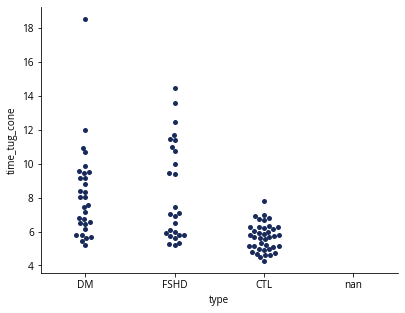

In [12]:
sns.swarmplot(data=df_part, x='type', y='time_tug_cone')


KeyError: 'mean_int_aa'

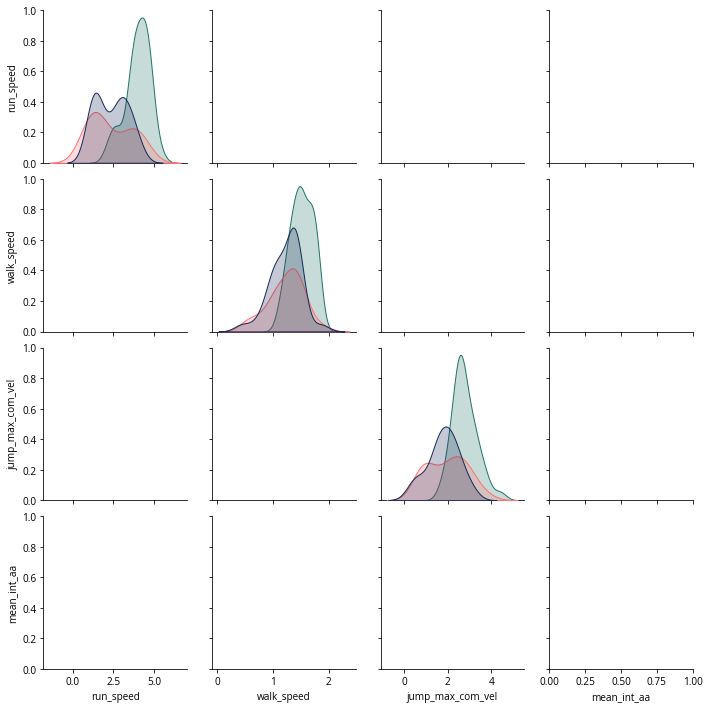

In [5]:
sns.pairplot(df_all,
             vars=['run_speed',
                   'walk_speed',
                   'jump_max_com_vel',
                   'mean_int_aa',
                  ],
             hue='type')
plt.show()


In [ ]:
sns.pairplot(df_all,
             vars=['mean_int_aa',
                   'int_com_elev',
                   'int_com_fwd',
                   'int_mean_heel_elev',
                  ],
             hue='type')
plt.show()


In [ ]:
sns.pairplot(df_all,
             vars=['brooke_max_mean_sa',
                   'max_mean_sa',
                   'curls_max_mean_ea',
                  ],
             hue='type')
plt.show()


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

def three_class_lda_cv(data, feats, label):
    df_train = data[['pid']+[label]+feats].dropna()

    X = df_train.loc[:,feats].values
    y = df_train.loc[:,label].values

    X -= X.mean(axis=0)
    X /= X.std(axis=0)

    lda = LinearDiscriminantAnalysis(n_components=2)

    df_out = df_train[['pid', 'type']].copy()
    df_out.loc[:,['lda1', 'lda2', 'pred']] = np.nan
    df_out.set_index('pid', inplace=True)
    df_out

    N_samples = X.shape[0]
    for k in range(N_samples):
        pid = df_out.index[k]
        X_train = X[np.arange(N_samples)!=k, :]
        y_train = y[np.arange(N_samples)!=k]
        lda.fit(X_train, y_train)
        ldas = lda.transform(X[k:k+1,:])
        df_out.loc[pid, ['lda1', 'lda2']] = ldas
        df_out.loc[pid, ['pred']] = lda.predict(X[k:k+1,:])

    acc = accuracy_score(y, df_out.pred)

    plt.figure(figsize=(5,4))
    sns.scatterplot(df_out, x='lda1', y='lda2', hue='type',
                    palette=[cp[0], cp[3], cp[1]],
                    hue_order=['DM', 'FSHD', 'CTL'],
                    s=15)
    plt.legend(loc='center left',
               # frameon=False, borderpad=0, borderaxespad=0,
               bbox_to_anchor=(1, 0.5))
    plt.title(f'Accuracy = {acc:0.3f}')
    sns.despine()
    plt.tight_layout()
    # plt.savefig('./temp_lda_oc.pdf')
    plt.show()
    
    return df_out

feats = oc_feats
feats = ['brooke_max_mean_sa', 'run_speed',
         'jump_max_com_vel', 'mean_int_aa']
df_out = three_class_lda_cv(df_all, feats, 'type')
df_out = three_class_lda_cv(df_all, tft_feats, 'type')
df_out = three_class_lda_cv(df_all, tfts_and_brooke, 'type')


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def two_class_log_reg(data, feats):
    df_train = data[['pid', 'type']+feats].dropna()
    X = df_train.loc[:,feats].values
    y = df_train['type'] != 'CTL'

    X_ctl = X[df_train.type == 'CTL',:].copy()
    # X -= X_ctl.mean(0)
    # X /= np.abs(X).max(0)
    # X /= X.std(0)
    X -= X.min(0)
    X /= X.max(0)
    
    clf_nmd = LogisticRegression(random_state=0)
    clf_nmd.fit(X, y)
    probas = clf_nmd.predict_proba(X)
    preds = clf_nmd.predict(X)

    df_out = df_train[['pid', 'type']].copy()
    df_out.loc[:,'NMD'] = y
    df_out.loc[:,'proba_NMD'] = probas[:,1]
    df_out.loc[:,'pred_NMD'] = preds
    df_out.set_index('pid', inplace=True)

    X_nmd = X[df_out.NMD,:]
    y_nmd = df_train.iloc[df_out.NMD.values]['type'] == 'DM'

    clf_dm = LogisticRegression(random_state=0)
    clf_dm.fit(X_nmd, y_nmd)
    probas = clf_dm.predict_proba(X)
    preds = clf_dm.predict(X)

    df_out.loc[:,'proba_DM'] = probas[:,1]
    df_out.loc[:,'pred_DM'] = preds
    
    fish = lambda row: 'CTL' if row['proba_NMD'] < 0.5 \
            else ('DM' if row['proba_DM'] > 0.5 else 'FSHD')
    df_out.loc[:,'pred'] = df_out.apply(fish, axis=1)
    
    acc = accuracy_score(df_train['type'], df_out.pred)

    plt.figure(figsize=(7,6))
    sns.scatterplot(df_out, x='proba_NMD', y='proba_DM', hue='type',
                    palette=[cp[0], cp[3], cp[1]],
                    hue_order=['DM', 'FSHD', 'CTL'],
                    s=15)
    plt.legend(loc='center left',
               # frameon=False, borderpad=0, borderaxespad=0,
               bbox_to_anchor=(1, 0.5))
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.axhline(0.5, c='k', lw=1)
    plt.axvline(0.5, c='k', lw=1)
    plt.title(f'Accuracy = {acc:0.3f}')
    sns.despine()
    plt.tight_layout()
    # plt.savefig('./temp_lda_oc.pdf')
    plt.show()

    return df_out, clf_nmd, clf_dm

def viz_2clr_features(feats, clf_nmd, clf_dm):
    feats = np.array(feats)
    coefs_nmd = clf_nmd.coef_.squeeze()
    coefs_dm = clf_dm.coef_.squeeze()
    
    plt.figure(figsize=(10,len(feats)*0.3))
    plt.subplot(1,2,1)
    signs = np.sign(coefs_nmd)
    colors = [cp[1] if s < 0 else cp[0] for s in signs]
    coefs = np.abs(clf_nmd.coef_.squeeze())
    order = np.argsort(coefs)
    plt.barh(feats[order],
             width=coefs[order],
             color=colors)
    sns.despine(bottom=True)
    plt.xticks([])
    plt.title('NMD Features')
    
    plt.subplot(1,2,2)
    signs = np.sign(coefs_dm)
    colors = [cp[1] if s < 0 else cp[0] for s in signs]
    coefs = np.abs(clf_dm.coef_.squeeze())
    order = np.argsort(coefs)
    plt.barh(feats[order],
             width=coefs[order],
             color=colors)
    sns.despine(bottom=True)
    plt.xticks([])
    plt.title('DM Features')
    plt.tight_layout()
    plt.show()

feats = oc_feats
# feats = ['brooke_max_mean_sa', 'curls_max_mean_ea',
#          'run_speed', 'jump_max_com_vel', 'mean_int_aa']
df_out, clf_nmd, clf_dm = two_class_log_reg(df_all, feats)
viz_2clr_features(feats, clf_nmd, clf_dm)

feats = tft_feats
df_out, clf_nmd, clf_dm = two_class_log_reg(df_all, tft_feats)
viz_2clr_features(feats, clf_nmd, clf_dm)

feats = tfts_and_brooke
df_out, clf_nmd, clf_dm = two_class_log_reg(df_all, feats)
viz_2clr_features(feats, clf_nmd, clf_dm)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

def two_class_lda(data, feats):
    df_train = data[['pid', 'type']+feats].dropna()

    X = df_train.loc[:,feats].values

    X_ctl = X[df_train.type == 'CTL',:].copy()
    X -= X_ctl.mean(0)
    X /= [std if std > 0 else 1 for std in X_ctl.std(0)]
    # X -= X.min(0)
    # X /= X.max(0)
    
    y = df_train.type != 'CTL'
    
    clf_nmd = LinearDiscriminantAnalysis(n_components=1)
    clf_nmd.fit(X, y)
    probas = clf_nmd.predict_proba(X)
    preds = clf_nmd.predict(X)

    df_out = df_train[['pid', 'type']].copy()
    df_out.loc[:,'NMD'] = y
    df_out.loc[:,'proba_NMD'] = probas[:,1]
    df_out.loc[:,'pred_NMD'] = preds
    df_out.loc[:,'lda_NMD'] = clf_nmd.transform(X)
    df_out.set_index('pid', inplace=True)

    X_nmd = X[df_out.NMD,:]
    y_nmd = df_train.iloc[df_out.NMD.values]['type'] == 'DM'

    clf_dm = LinearDiscriminantAnalysis(n_components=1)
    clf_dm.fit(X_nmd, y_nmd)
    probas = clf_dm.predict_proba(X)
    preds = clf_dm.predict(X)

    df_out.loc[:,'proba_DM'] = probas[:,1]
    df_out.loc[:,'pred_DM'] = preds
    df_out.loc[:,'lda_DM'] = clf_dm.transform(X)

    fish = lambda row: 'CTL' if row['proba_NMD'] < 0.5 \
            else ('DM' if row['proba_DM'] > 0.5 else 'FSHD')
    df_out.loc[:,'pred'] = df_out.apply(fish, axis=1)
    
    acc = accuracy_score(df_train['type'], df_out.pred)

    plt.figure(figsize=(6,5))
    # sns.scatterplot(df_out, x='proba_NMD', y='proba_DM', hue='type',
    sns.scatterplot(df_out, x='lda_NMD', y='lda_DM', hue='type',
                    palette=[cp[0], cp[3], cp[1]],
                    hue_order=['DM', 'FSHD', 'CTL'],
                    s=15)
    plt.legend(loc='center left',
               # frameon=False, borderpad=0, borderaxespad=0,
               bbox_to_anchor=(1, 0.5))
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.axhline(0, c='k', lw=1)
    plt.axvline(0, c='k', lw=1)
    plt.title(f'Accuracy = {acc:0.3f}')
    sns.despine()
    plt.tight_layout()
    # plt.savefig('./temp_lda_oc.pdf')
    plt.show()

    return df_out, clf_nmd, clf_dm

def viz_2clr_features(feats, clf_nmd, clf_dm):
    feats = np.array(feats)
    coefs_nmd = clf_nmd.coef_.squeeze()
    coefs_dm = clf_dm.coef_.squeeze()
    
    plt.figure(figsize=(10,len(feats)*0.3))
    plt.subplot(1,2,1)
    signs = np.sign(coefs_nmd)
    colors = [cp[1] if s < 0 else cp[0] for s in signs]
    coefs = np.abs(clf_nmd.coef_.squeeze())
    order = np.argsort(coefs)
    plt.barh(feats[order],
             width=coefs[order],
             color=colors)
    sns.despine(bottom=True)
    plt.xticks([])
    plt.title('NMD Features')
    
    plt.subplot(1,2,2)
    signs = np.sign(coefs_dm)
    colors = [cp[1] if s < 0 else cp[0] for s in signs]
    coefs = np.abs(clf_dm.coef_.squeeze())
    order = np.argsort(coefs)
    plt.barh(feats[order],
             width=coefs[order],
             color=colors)
    sns.despine(bottom=True)
    plt.xticks([])
    plt.title('DM Features')
    plt.tight_layout()
    plt.show()

feats = oc_feats
feats = ['brooke_max_mean_sa', 'curls_max_mean_ea',
         'run_speed', 'jump_max_com_vel', 'mean_int_aa']
df_out, clf_nmd, clf_dm = two_class_lda(df_all, feats)
viz_2clr_features(feats, clf_nmd, clf_dm)

feats = tft_feats
df_out, clf_nmd, clf_dm = two_class_lda(df_all, tft_feats)
viz_2clr_features(feats, clf_nmd, clf_dm)

feats = tfts_and_brooke
df_out, clf_nmd, clf_dm = two_class_lda(df_all, feats)
viz_2clr_features(feats, clf_nmd, clf_dm)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

data = df_all

def two_class_lda_cv(data, feats):

    data = data[['pid', 'type']+feats].dropna()
    data.set_index('pid', inplace=True)

    X = data.loc[:,feats].values

    X_ctl = X[data.type == 'CTL'].copy()
    X -= X_ctl.mean(0)
    X /= [std if std > 0 else 1 for std in X_ctl.std(0)]
    y = data.type != 'CTL'

    df_out = data[['type']].copy()
    df_out.loc[:,'NMD'] = y

    df_out.loc[:,['proba_NMD', 'pred_NMD', 'lda_NMD']] = np.nan
    clf_nmd = LinearDiscriminantAnalysis(n_components=1)
    N_samples = X.shape[0]
    for k in range(N_samples):
        pid = data.index[k]
        X_train = X[np.arange(N_samples)!=k, :]
        y_train = y[np.arange(N_samples)!=k]
        clf_nmd.fit(X_train, y_train)
        df_out.loc[pid, 'proba_NMD'] = clf_nmd.predict_proba(X[k:k+1,:]).squeeze()[1]
        df_out.loc[pid, 'pred_NMD'] = clf_nmd.predict(X[k:k+1,:]).squeeze()
        df_out.loc[pid, 'lda_NMD'] = clf_nmd.transform(X[k:k+1,:]).squeeze()

    X_nmd = X[df_out.NMD,:]
    y_nmd = data.iloc[df_out.NMD.values]['type'] == 'DM'

    df_out.loc[:,['proba_DM', 'pred_DM', 'lda_DM']] = np.nan
    clf_dm = LinearDiscriminantAnalysis(n_components=1)
    N_samples = X_nmd.shape[0]
    for k in range(N_samples):
        pid = data.index.values[df_out.NMD][k]
        X_train = X_nmd[np.arange(N_samples)!=k, :]
        y_train = y_nmd[np.arange(N_samples)!=k]
        clf_dm.fit(X_train, y_train)
        df_out.loc[pid, 'proba_DM'] = clf_dm.predict_proba(X[k:k+1,:]).squeeze()[1]
        df_out.loc[pid, 'pred_DM'] = clf_dm.predict(X[k:k+1,:]).squeeze()
        df_out.loc[pid, 'lda_DM'] = clf_dm.transform(X[k:k+1,:]).squeeze()

    clf_dm.fit(X_nmd, y_nmd)
    X_ctl = X[~df_out.NMD,:]
    df_out.loc[~df_out.NMD, 'proba_DM'] = clf_dm.predict_proba(X_ctl).squeeze()[:,1]
    df_out.loc[~df_out.NMD, 'pred_DM'] = clf_dm.predict(X_ctl).squeeze()
    df_out.loc[~df_out.NMD, 'lda_DM'] = clf_dm.transform(X_ctl).squeeze()

    fish = lambda row: 'CTL' if row['proba_NMD'] < 0.5 \
            else ('DM' if row['proba_DM'] > 0.5 else 'FSHD')
    df_out.loc[:,'pred'] = df_out.apply(fish, axis=1)

    acc = accuracy_score(data['type'], df_out.pred)

    plt.figure(figsize=(6,5))
    # sns.scatterplot(df_out, x='proba_NMD', y='proba_DM', hue='type',
    sns.scatterplot(df_out, x='lda_NMD', y='lda_DM', hue='type',
                    palette=[cp[0], cp[3], cp[1]],
                    hue_order=['DM', 'FSHD', 'CTL'],
                    s=15)
    plt.legend(loc='center left',
               # frameon=False, borderpad=0, borderaxespad=0,
               bbox_to_anchor=(1, 0.5))
    plt.axhline(0, c='k', lw=1)
    plt.axvline(0, c='k', lw=1)
    plt.title(f'Accuracy = {acc:0.3f}')
    sns.despine()
    plt.tight_layout()
    # plt.savefig('./temp_lda_oc.pdf')
    plt.show()

    return df_out

df_out = two_class_lda_cv(df_all, oc_feats)

df_out = two_class_lda_cv(df_all, tft_feats)

df_out = two_class_lda_cv(df_all, tfts_and_brooke)
